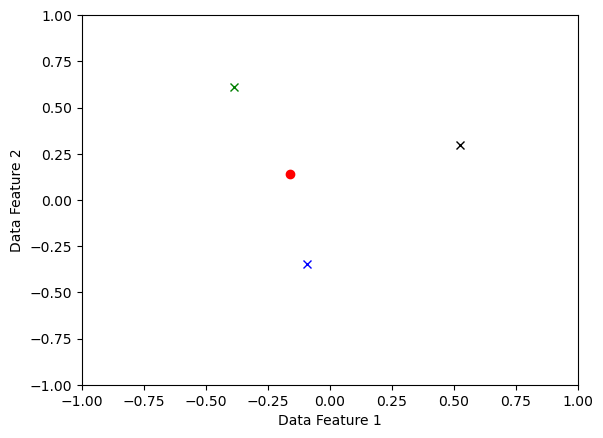

['0', '0', '0']
According to our distance algorithm,
 the new data point belongs to the Green class.

Euclidean distances:  [0.5202853247978458, 0.4905204028376394, 0.7014755294377703] 

According to euclidean distance calculations,
 the new data point belongs to the Blue class.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import math
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT, DraperQFTAdder

fig, ax = plt.subplots()
ax.set(xlabel='Data Feature 1', ylabel='Data Feature 2')

# Get the data from the .csv file
data = pd.read_csv('kmeans_data.csv',
    usecols=['Feature 1', 'Feature 2', 'Class'])

# Create binary variables to filter data
isGreen = data['Class'] == 'Green'
isBlue = data['Class'] == 'Blue'
isBlack = data['Class'] == 'Black'

# Filter data
greenData = data[isGreen].drop(['Class'], axis=1)
blueData = data[isBlue].drop(['Class'], axis=1)
blackData = data[isBlack].drop(['Class'], axis=1)

# This is the point we need to classify
y_p = 0.141
x_p = -0.161

# Finding the x-coords of the centroids
xgc = sum(greenData['Feature 1']) / len(greenData['Feature 1'])
xbc = sum(blueData['Feature 1']) / len(blueData['Feature 1'])
xkc = sum(blackData['Feature 1']) / len(blackData['Feature 1'])

# Finding the y-coords of the centroids
ygc = sum(greenData['Feature 2']) / len(greenData['Feature 2'])
ybc = sum(blueData['Feature 2']) / len(blueData['Feature 2'])
ykc = sum(blackData['Feature 2']) / len(blackData['Feature 2'])

# Plotting the centroids
plt.plot(xgc, ygc, 'gx')
plt.plot(xbc, ybc, 'bx')
plt.plot(xkc, ykc, 'kx')

# Plotting the new data point
plt.plot(x_p, y_p, 'ro')

# Setting the axis ranges
plt.axis([-1, 1, -1, 1])

plt.show()

# Calculating theta and phi values
phi_list = [((x + 1) * math.pi / 2) for x in [x_p, xgc, xbc, xkc]]
theta_list = [((x + 1) * math.pi / 2) for x in [y_p, ygc, ybc, ykc]]

# Create a 2 qubit QuantumRegister - two for the vectors, and 
# one for the ancillary qubit
qreg = QuantumRegister(3, 'qreg')

# Create a one bit ClassicalRegister to hold the result
# of the measurements
creg = ClassicalRegister(1, 'creg')

qc = QuantumCircuit(qreg, creg, name='qc')

# Get backend using the Aer provider
simulator = AerSimulator()

# Create list to hold the results
results_list = []

# Estimating distances from the new point to the centroids
for i in range(1, 4):
    # Apply a Hadamard to the ancillary
    qc.h(qreg[2])

    # Encode new point and centroid
    qc.u(theta_list[0], phi_list[0], 0, qreg[0])           
    qc.u(theta_list[i], phi_list[i], 0, qreg[1]) 

    # Perform controlled swap
    qc.cswap(qreg[2], qreg[0], qreg[1])
    # Apply second Hadamard to ancillary
    qc.h(qreg[2])

    # Measure ancillary
    qc.measure(qreg[2], creg[0])

    # Reset qubits
    qc.reset(qreg)

    # Register and execute job
    circ = transpile(qc, simulator)
    result = simulator.run(circ).result()
    counts = result.get_counts(circ)
    results_list.append(max(counts, key=counts.get))

print(results_list)

# Create a list to hold the possible classes
class_list = ['Green', 'Blue', 'Black']

# Find out which class the new data point belongs to 
# according to our distance estimation algorithm
quantum_p_class = class_list[results_list.index(min(results_list))]

# Find out which class the new data point belongs to 
# according to classical euclidean distance calculation
distances_list = [((x_p - i[0])**2 + (y_p - i[1])**2)**0.5 for i in [(xgc, ygc), (xbc, ybc), (xkc, ykc)]]
classical_p_class = class_list[distances_list.index(min(distances_list))]

# Print results
print("""According to our distance algorithm,
 the new data point belongs to the""", quantum_p_class, 
 'class.\n')
print('Euclidean distances: ', distances_list, '\n')
print("""According to euclidean distance calculations,
 the new data point belongs to the""", classical_p_class, 
 'class.')